In [1]:
# Generic
from pathlib import Path
import typing

# Numerical Computing
import numpy as np
import torch
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str, sanitize_fname
from muutils.nbutils.configure_notebook import configure_notebook

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.plotting import MazePlot, PathFormat
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ZanjHookedTransformer

# mechinterp stuff
from maze_transformer.mechinterp.logit_attrib_task import LOGIT_ATTRIB_TASKS
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data
from maze_transformer.evaluation.eval_single_token_tasks import TaskPrompt, TaskEvalResult, get_task_prompts_targets, eval_model_across_tasks, plot_task_accuracy, eval_model_task
from maze_transformer.evaluation.plotting import plot_predicted_paths
from maze_transformer.mechinterp.plot_logits import get_baseline_incorrect_group, plot_logit_histograms
from maze_transformer.evaluation.baseline_models import RandomBaseline
from maze_transformer.mechinterp.direct_logit_attribution import plot_direct_logit_attribution


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cuda')


In [3]:

MODELS_PATHS: list[str] = [
	# "../examples/model.hallway-insto.v17.zanj",
	# "../examples/model.hallway-insto.final.zanj",
	# "../examples/wandb.jerpkipj.zanj",
	# "../examples/hallway-orig.zanj",
	"../examples/model.hallway-jvq.final.zanj",
]

DATASET_CFG_SOURCE: MazeDatasetConfig = MazeDatasetConfig(
	name="dfs",
	# name="hallway",
	grid_n=7,
	n_mazes=50,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
	# maze_ctor_kwargs=dict(do_forks=False),
)

In [8]:
def all_plots(
	model_path: str,
	dataset_cfg_source: MazeDatasetConfig,
	plot_dir: Path|str = "plots/",
	do_titles: bool = True,
	do_task_accuracy: bool = True,
) -> None:
	model, dataset = load_model_with_test_data(
		model_path=model_path,
		dataset_cfg_source=dataset_cfg_source,
		n_examples=50,
	)

	title_suffix: str = f"model: {model.config.name}\ndataset: {dataset.cfg.to_fname()}"
	file_id: str = sanitize_fname(f"{model.config.name}.{dataset.cfg.to_fname()}")
	plot_dir = Path(plot_dir) / file_id
	plot_dir.mkdir(parents=True, exist_ok=True)

	# rollouts
	fig, ax = plot_predicted_paths(
		model=model,
		dataset=dataset,
		n_mazes=5, 
		max_new_tokens=50, 
		row_length=5, 
		figsize_scale=5,
		predicted_path_fmt=PathFormat(cmap="winter"),
		show=False,
	)

	if do_titles:
		fig.suptitle(f"Predicted Paths\n{title_suffix}", fontsize=20)
		# make the figure taller
		fig.set_figheight(fig.get_figheight() + 1)
	fig.savefig(plot_dir / "rollouts.pdf", bbox_inches="tight")
	plt.show()

	tokenizer: MazeTokenizer = model.zanj_model_config.maze_tokenizer
	task_prompts_targets: dict[str, TaskPrompt] = get_task_prompts_targets(
		dataset=dataset,
		maze_tokenizer=tokenizer,
		tasks=LOGIT_ATTRIB_TASKS,
	)

	# task accuracy
	if do_task_accuracy:
		task_results: dict[str, TaskEvalResult] = eval_model_across_tasks(
			model = model,
			task_prompts = task_prompts_targets,
			do_cache=False,
		)

		fig, ax = plot_task_accuracy(task_results)
		if do_titles:
			fig.suptitle(f"Prediction accuracy across tasks\n{title_suffix}")
			fig.set_figheight(fig.get_figheight() + 1.1)
		fig.savefig(plot_dir / "task_accuracy.pdf", bbox_inches="tight")
		
		del task_results # delete so no CooM?

	baseline: RandomBaseline = RandomBaseline(model.config)

	histograms_plot_dir: Path = plot_dir / f"logit_histograms"
	histograms_plot_dir.mkdir(parents=True, exist_ok=True)


	task_result: TaskEvalResult
	for task_name, task in task_prompts_targets.items():
		print(f"running {task_name = }")
		task_result = eval_model_task(
			model=model,
			task=task,
			do_cache=True,
		)

		# skip the path_start task since baseline model wont do it
		if task_name == "path_start":
			continue

		prompts: list[list[str]]; targets: list[str]
		prompts, targets = task_prompts_targets[task_name]

		incorrect_but_valid: Bool[torch.Tensor, "n_mazes d_vocab"] = get_baseline_incorrect_group(
			prompts=prompts,
			tokenizer=tokenizer,
			baseline=baseline,
		)

		ax_logit_hist = plot_logit_histograms(
			last_tok_logits=task_result.last_tok_logits,
			target_idxs=torch.tensor(tokenizer.encode(targets)),
			token_groups={
				"grid adjacent but incorrect": incorrect_but_valid,
			},
			show_all_other_tokens=True,
			n_bins=50,
			density=False,
			logy=True,
		)
		if do_titles:
			ax_logit_hist.set_title(f"Logit Histograms for '{task_name}' task\n{title_suffix}")

		fig_logit_hist = ax_logit_hist.get_figure()
		fig_logit_hist.savefig(histograms_plot_dir / f"{task_name}.pdf", bbox_inches="tight")

		dla_fig, dla_ax, dla_data = plot_direct_logit_attribution(
			model=model,
			cache=task_result.cache,
			answer_tokens=torch.tensor(tokenizer.encode(targets)),
			show=False,
			# layer_index_normalization=lambda contrib, layer_index: contrib / ((layer_index+1)**2),
		)
		dla_ax[0].set_title(task_name)
		dla_fig[0].savefig(plot_dir / f"{task_name}.dla-heads.pdf", bbox_inches='tight')



loaded model with 1.2M params (num_params = 1238076) from
../examples/model.hallway-jvq.final.zanj
original model name: 'model.zanj_model_config.name = 'hallway_v3'', changing to 'hallway-jvq.final'
loaded dataset with 50 examples
dataset.cfg.summary() = {'name': 'dfs', 'fname': 'dfs-g7-n50-a_dfs-h30157', 'sdc_hash': 15812975409377289206935077889735135135540819604465975603792668444009796430157, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 7, 'grid_shape': (7, 7), 'n_mazes': 50, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {}}


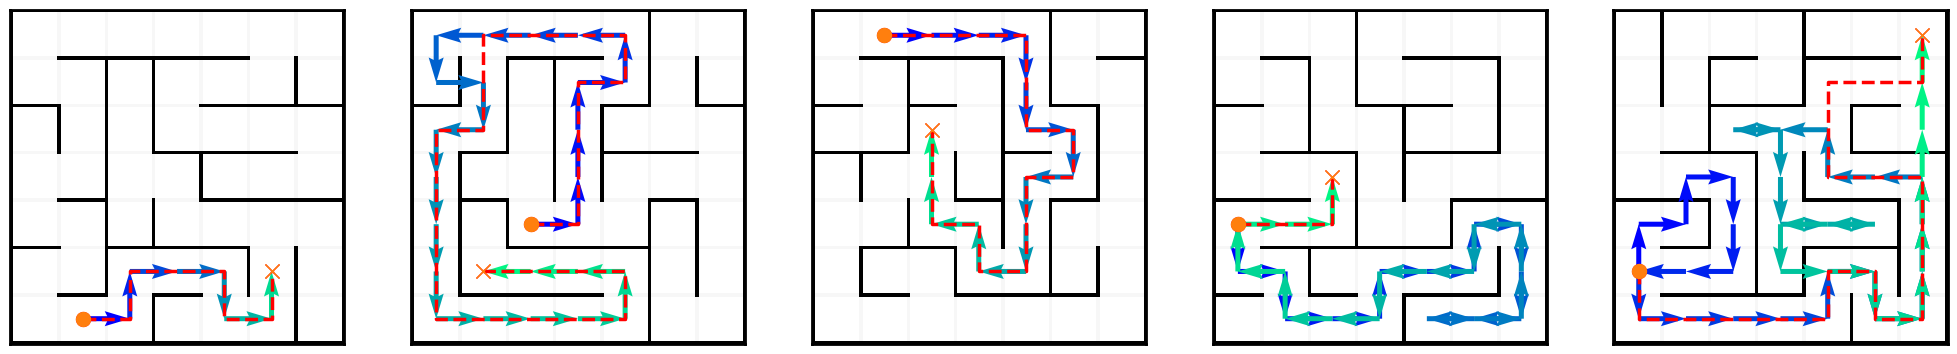

running task_name = 'path_start'
running task_name = 'origin_after_path_start'
answer_tokens.shape = torch.Size([50])
n_layers = 6, n_heads = 4, d_model = 128
n_layers * n_heads = 24
n_layers * mlp_dim = 3072
Tried to stack head results when they weren't cached. Computing head results now
per_head_residual.shape = torch.Size([24, 50, 128])
per_head_logit_diffs.shape = torch.Size([24])
per_head_logit_diffs.shape = torch.Size([6, 4])
per_neuron_residual.shape = torch.Size([3072, 50, 128])
per_neuron_logit_diffs.shape = torch.Size([3072])
per_neuron_logit_diffs.shape = torch.Size([6, 512])
running task_name = 'first_path_choice'
answer_tokens.shape = torch.Size([50])
n_layers = 6, n_heads = 4, d_model = 128
n_layers * n_heads = 24
n_layers * mlp_dim = 3072
Tried to stack head results when they weren't cached. Computing head results now
per_head_residual.shape = torch.Size([24, 50, 128])
per_head_logit_diffs.shape = torch.Size([24])
per_head_logit_diffs.shape = torch.Size([6, 4])
per_neuro

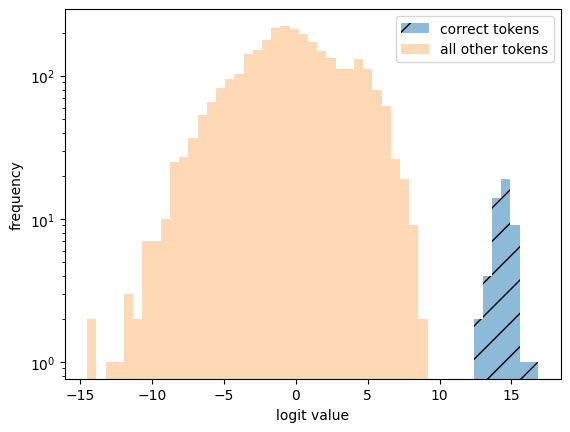

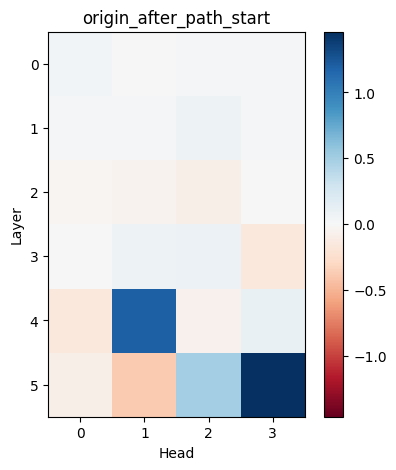

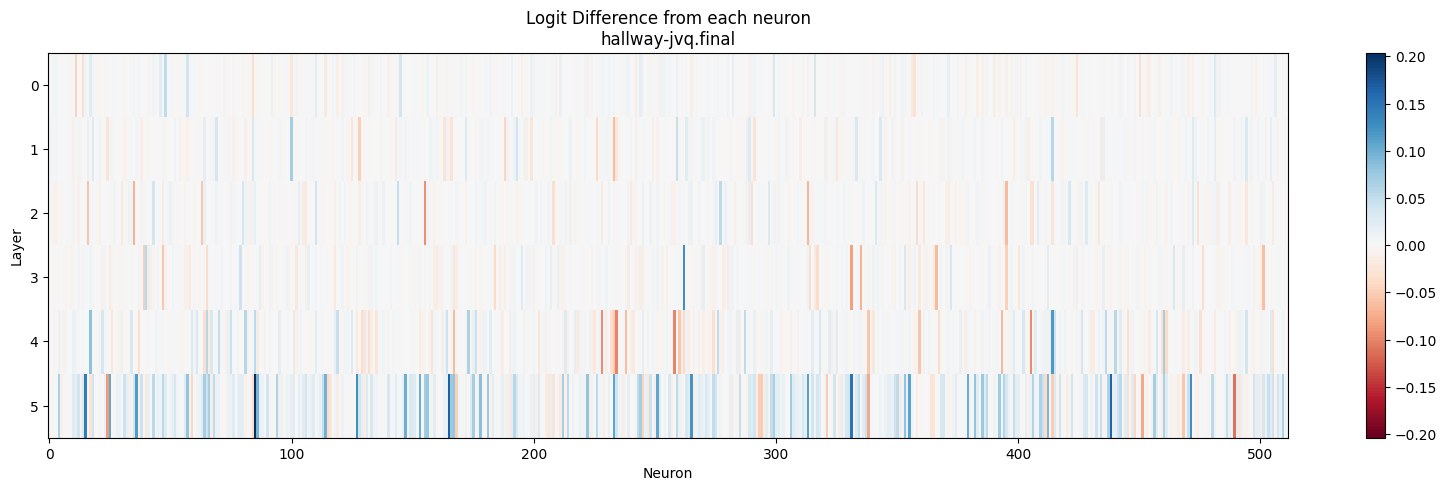

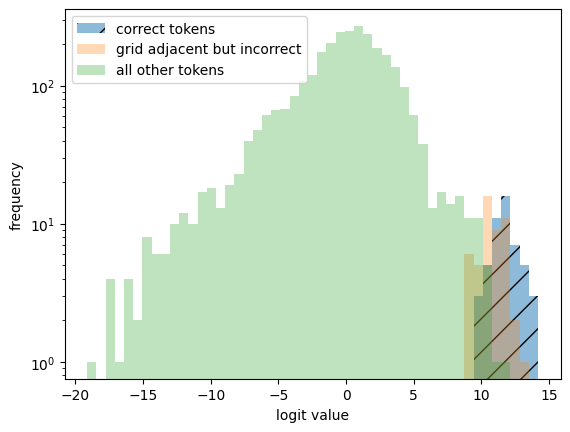

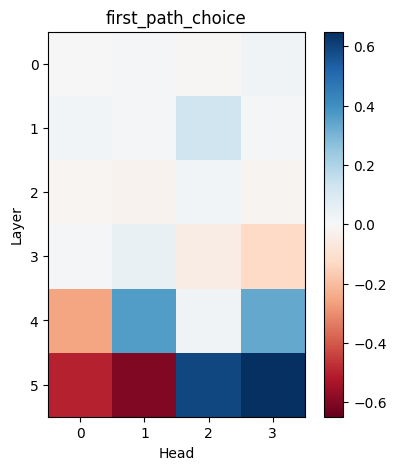

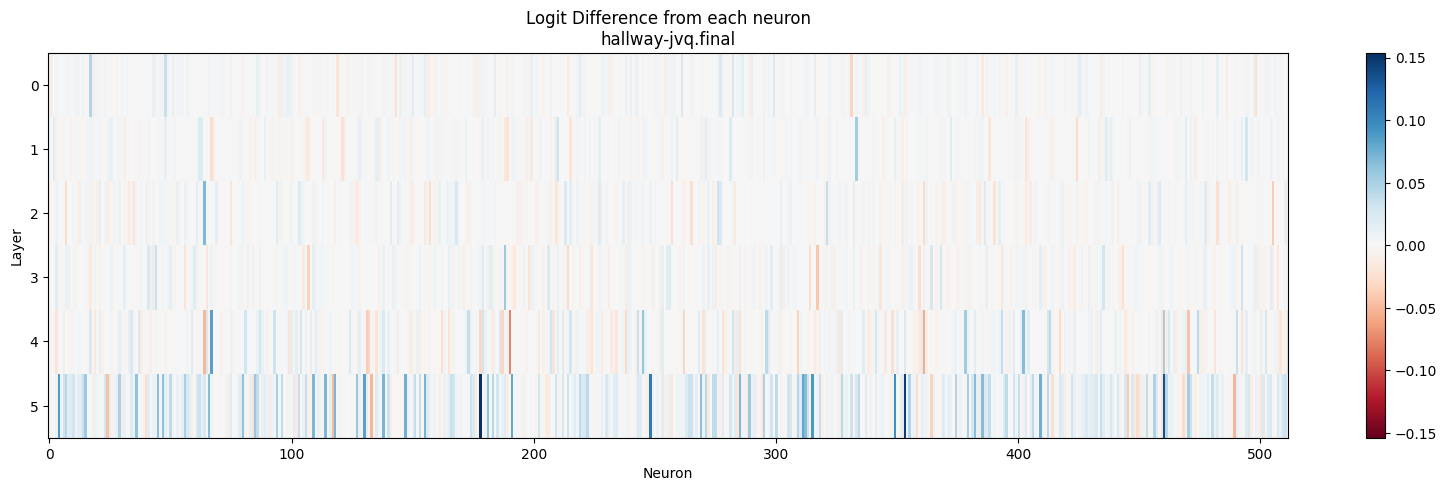

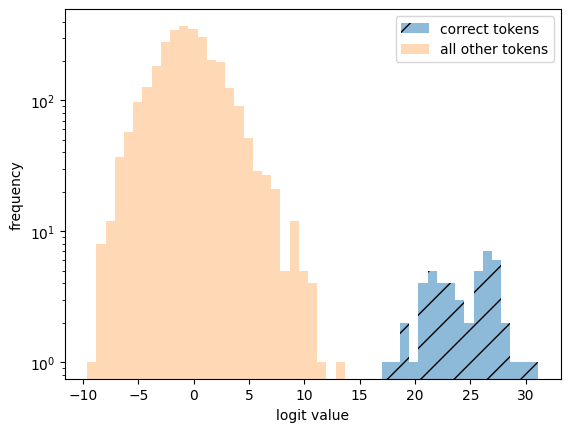

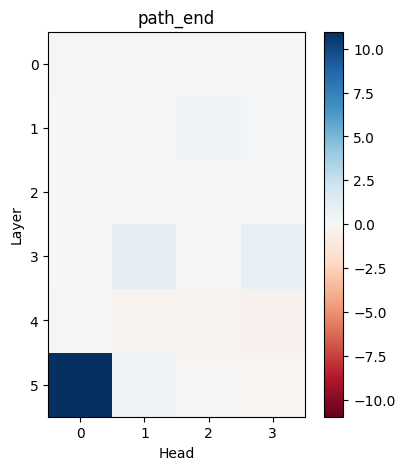

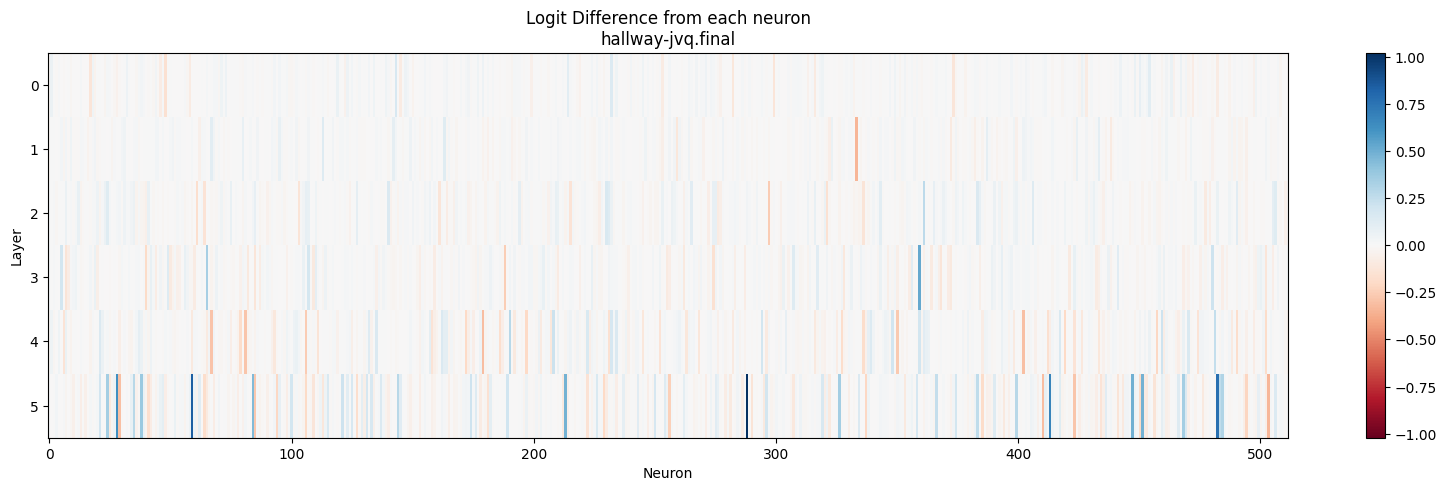

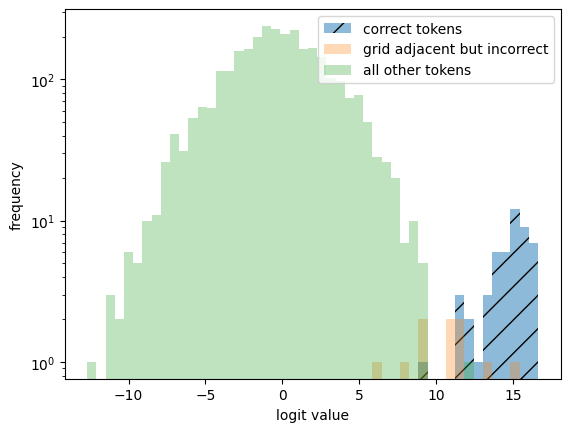

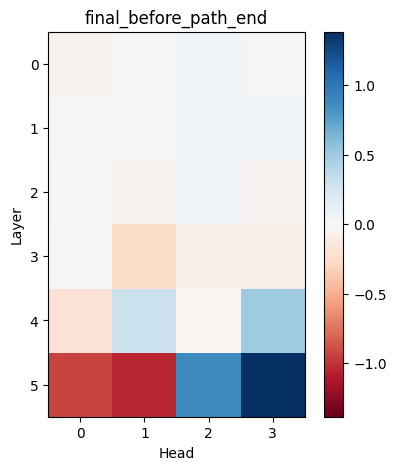

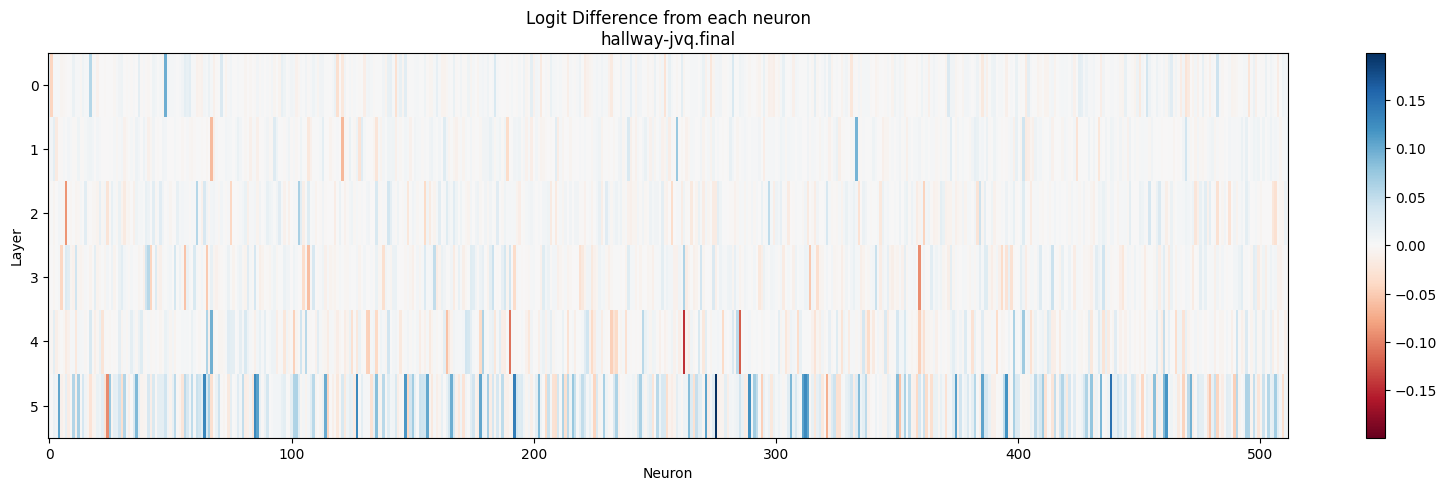

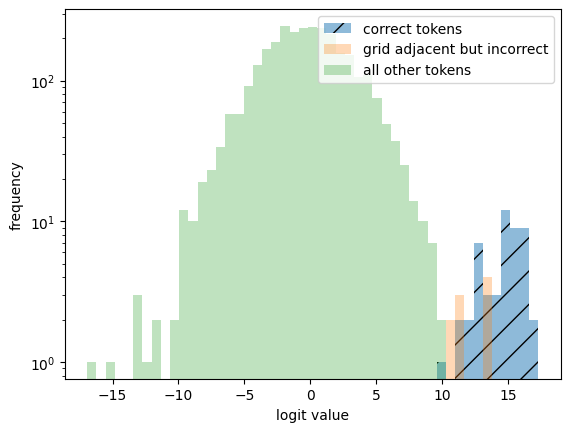

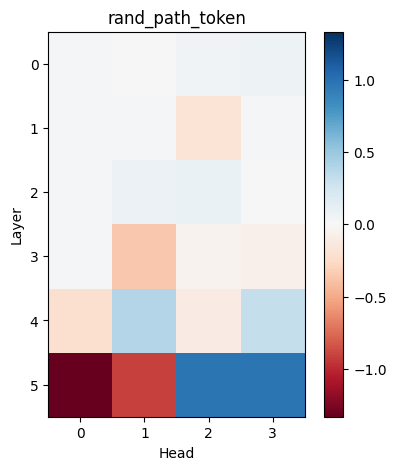

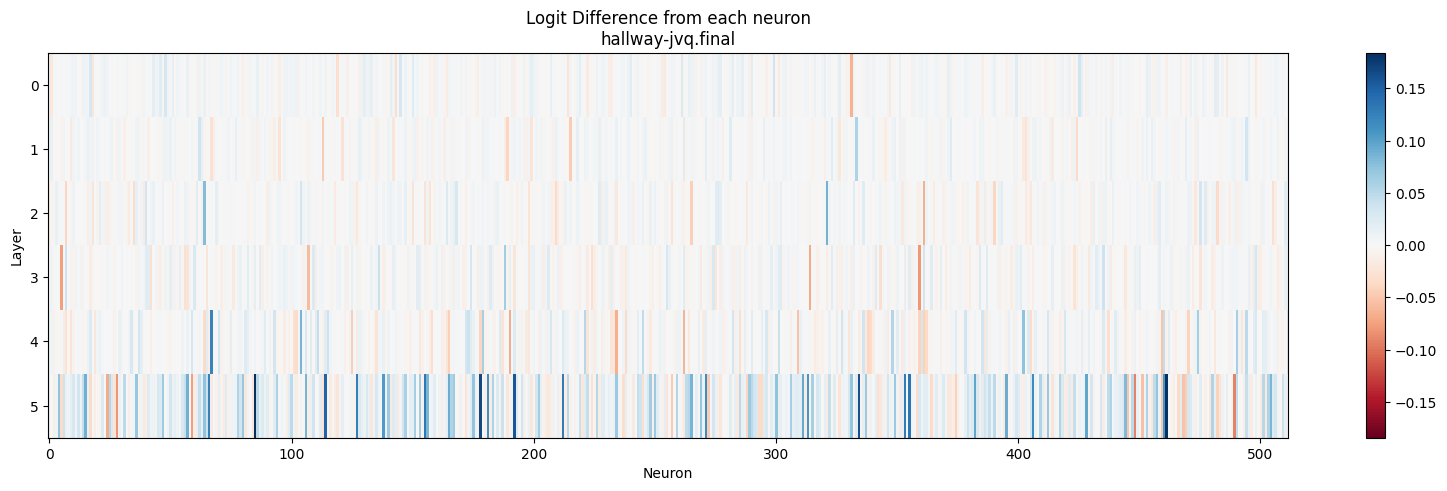

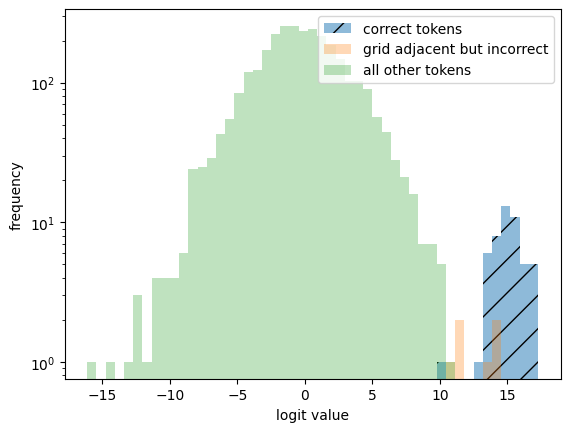

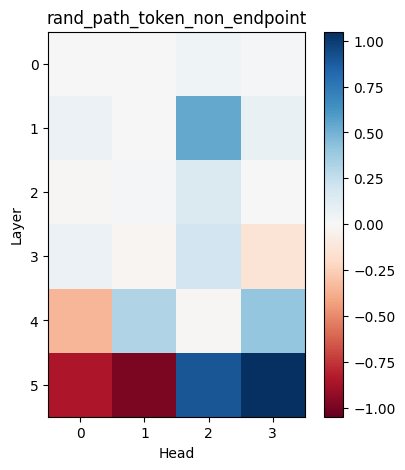

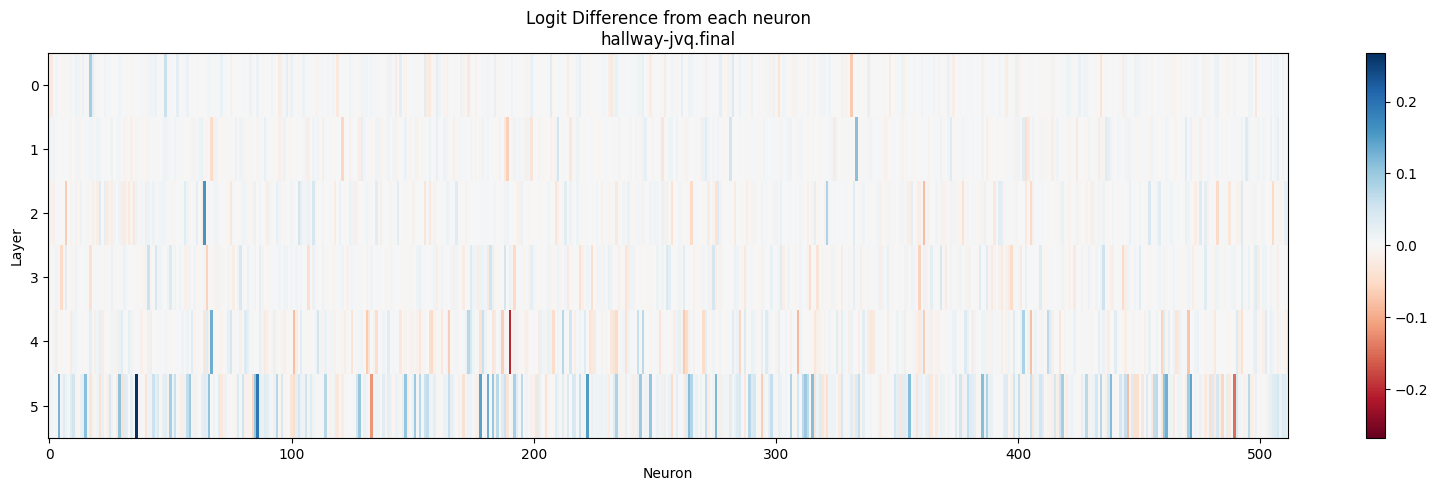

In [9]:
for model_path in MODELS_PATHS:
	all_plots(
		model_path, 
		DATASET_CFG_SOURCE,
		do_titles=False,
		do_task_accuracy=False,
	)